In [14]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
from PIL import Image
import torch
from sklearn.model_selection import train_test_split
import pandas as pd
from torchvision.transforms import transforms, Compose, ToTensor, Resize, Normalize, CenterCrop, Grayscale
from torch import nn
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import math

In [15]:
class SnakeDataSet(Dataset):
    def __init__(self, dataframe, root_dir, stack_size, transform = None):
        self.stack_size = stack_size
        self.key_frame = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_frame) - self.stack_size *3

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        try:
            img_names = [os.path.join(self.root_dir, self.key_frame.iloc[idx + i, 0]) for i in range(self.stack_size)]
            images = [Image.open(img_name) for img_name in img_names]
            label = torch.tensor(self.key_frame.iloc[idx + self.stack_size, 1])
            if self.transform:
                images = [self.transform(image) for image in images]
        except:
            img_names = [os.path.join(self.root_dir, self.key_frame.iloc[0 + i, 0]) for i in range(self.stack_size)]
            images = [Image.open(img_name) for img_name in img_names]
            label = torch.tensor(self.key_frame.iloc[0 + self.stack_size, 1])
            if self.transform:
                images = [self.transform(image) for image in images]
        return torch.stack(images,dim = 1).squeeze(), label

In [16]:
transformer = Compose([
    Grayscale(1),
    Resize((84,84), antialias=True),
    CenterCrop(84),
    ToTensor(),
    Normalize(mean =[0.6974], std =[0.6974] )
])

In [17]:
STACK_SIZE = 4

train, test = train_test_split(pd.read_csv("data/labels_snake.csv")[:40000], test_size=0.2, shuffle=False)
classes = ["n", "left", "up", "right", "down"]

labels_unique, counts = np.unique(train["class"], return_counts=True)
class_weights = [sum(counts)/c for c in counts]
example_weights = np.array([class_weights[l] for l in train['class']])
example_weights = np.roll(example_weights, -STACK_SIZE)
sampler = WeightedRandomSampler(example_weights, len(train))

labels_unique, counts = np.unique(test["class"], return_counts=True)
class_weights = [sum(counts)/c for c in counts]
test_example_weights = np.array([class_weights[l] for l in test['class']])
test_example_weights = np.roll(test_example_weights, -STACK_SIZE)
test_sampler = WeightedRandomSampler(test_example_weights, len(test))

In [18]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
dataset = SnakeDataSet(root_dir="captures", dataframe = train, stack_size=STACK_SIZE, transform=transformer)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler, drop_last= True)
test_dataset = SnakeDataSet(root_dir="captures", dataframe = test, stack_size=STACK_SIZE,  transform=transformer)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, sampler = test_sampler, drop_last=True)


In [19]:
def compute_mean_std(dataloader):
    '''
    We assume that the images of the dataloader have the same height and width
    source: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/Basics/pytorch_std_mean.py
    '''
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0

    for batch_images, labels in tqdm(dataloader):  # (B,H,W,C)
        batch_images = batch_images.permute(0,2,3,1)
        channels_sum += torch.mean(batch_images, dim=[0, 1, 2])
        channels_sqrd_sum += torch.mean(batch_images ** 2, dim=[0, 1, 2])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [20]:
# compute_mean_std(dataloader)

tensor([0, 1, 3, 2, 0, 2, 1, 0, 3, 1, 3, 2, 1, 2, 0, 0, 1, 2, 1, 0, 3, 2, 3, 1,
        2, 0, 1, 3, 4, 3, 3, 2])


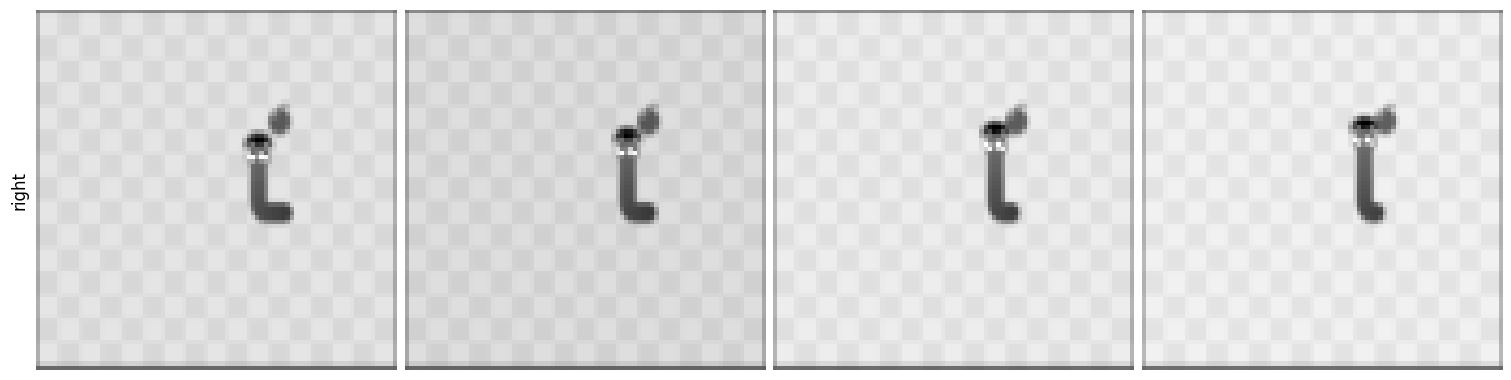

In [21]:
images, label = next(iter(dataloader))
print(label)
from matplotlib.pyplot import subplots
fig,ax = subplots(1, STACK_SIZE, constrained_layout = True, figsize=(15,5))
for i in range(STACK_SIZE):
    ax[i].imshow(images[2][i,:,:],cmap="gray");
    ax[i].axis('off')
fig.supylabel(classes[label[2].item()]);

In [22]:
class SnakeModel(nn.Module):
    def __init__(self, in_channels=4, out_channels=32, mlp_size=256, n_actions=5, dropout = 0.2):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.mlp_size = mlp_size
        self.n_classes = n_actions
        self.convblock = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4,2),
            nn.ReLU()
        )
        self.classifier =nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=out_channels*9*9, out_features=mlp_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_size, out_features=n_actions)
        )

    def forward(self,x):
        x = self.classifier(self.convblock(x).permute(0,2,3,1))
        return x

In [23]:
model = SnakeModel()
summary(model, [BATCH_SIZE, 4, 84,84])


Layer (type:depth-idx)                   Output Shape              Param #
SnakeModel                               [32, 5]                   --
├─Sequential: 1-1                        [32, 32, 9, 9]            --
│    └─Conv2d: 2-1                       [32, 16, 20, 20]          4,112
│    └─ReLU: 2-2                         [32, 16, 20, 20]          --
│    └─Conv2d: 2-3                       [32, 32, 9, 9]            8,224
│    └─ReLU: 2-4                         [32, 32, 9, 9]            --
├─Sequential: 1-2                        [32, 5]                   --
│    └─Flatten: 2-5                      [32, 2592]                --
│    └─Linear: 2-6                       [32, 256]                 663,808
│    └─ReLU: 2-7                         [32, 256]                 --
│    └─Dropout: 2-8                      [32, 256]                 --
│    └─Linear: 2-9                       [32, 5]                   1,285
Total params: 677,429
Trainable params: 677,429
Non-trainable params: 0

In [24]:
from torch.optim.lr_scheduler import LinearLR
num_epochs = 7

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.AdamW(model.parameters(), 10e-5, weight_decay=0.1)
model.to(device)
criterion = nn.CrossEntropyLoss()

In [25]:
steps = 0
for epoch in range(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    val_loss = 0.0
    val_correct_predictions = 0
    val_total_samples = 0

    # Set model to training mode
    model.train()

    # tqdm bar for progress visualization
    pbar = tqdm(dataloader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=True)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        _, predicted = torch.max(torch.softmax(outputs,1), 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Update tqdm bar with current loss and accuracy
        pbar.set_postfix({'Loss': total_loss / total_samples, 'Accuracy': correct_predictions / total_samples})
        steps = steps + 1
        # if steps>1000:
        #     for param_group in optimizer.param_groups:
        #         param_group['lr'] = 2e-5

    model.eval()
    with torch.inference_mode():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels)

            # Update statistics
            val_loss += loss.item()
            _, predicted = torch.max(torch.softmax(outputs,1), 1)
            val_correct_predictions += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)

    # Calculate and print epoch-level accuracy and loss for validation
    epoch_loss = val_loss / val_total_samples
    epoch_accuracy = val_correct_predictions / val_total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_accuracy:.4f}')

Epoch 1/7: 100%|██████████| 1000/1000 [07:17<00:00,  2.28it/s, Loss=0.0426, Accuracy=0.432]


Epoch 1/7, Val Loss: 0.0496, Val Accuracy: 0.3450


Epoch 2/7: 100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s, Loss=0.0287, Accuracy=0.646]


Epoch 2/7, Val Loss: 0.0601, Val Accuracy: 0.3710


Epoch 3/7: 100%|██████████| 1000/1000 [06:34<00:00,  2.53it/s, Loss=0.0191, Accuracy=0.779]


Epoch 3/7, Val Loss: 0.0728, Val Accuracy: 0.3314


Epoch 4/7: 100%|██████████| 1000/1000 [06:27<00:00,  2.58it/s, Loss=0.0148, Accuracy=0.831]


Epoch 4/7, Val Loss: 0.0854, Val Accuracy: 0.3174


Epoch 5/7: 100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s, Loss=0.0122, Accuracy=0.862]


Epoch 5/7, Val Loss: 0.0946, Val Accuracy: 0.3026


Epoch 6/7: 100%|██████████| 1000/1000 [07:11<00:00,  2.32it/s, Loss=0.0104, Accuracy=0.885]


Epoch 6/7, Val Loss: 0.1020, Val Accuracy: 0.2810


Epoch 7/7: 100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s, Loss=0.0094, Accuracy=0.896]


Epoch 7/7, Val Loss: 0.1100, Val Accuracy: 0.2891


In [26]:
torch.save(model.state_dict(), "model.pth")